In [1]:
import sys
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import numpy as np; np.random.seed(0)
import threadpoolctl
import copy
from collections import Counter

threadpoolctl.threadpool_limits(limits=8)
sc.settings.verbosity = 3
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from typing import Any
def scatter_viz(x: np.ndarray, y: np.ndarray, *args: Any, **kwargs: Any) -> Any:
    """A wrapper of scatter plot that guarantees that every point is visible in a very crowded scatterplot
    Args
    ----
    x: np.ndarray
        x axis coordinates
    y: np.ndarray
        y axis coordinates
    args and kwargs:
        positional and keyword arguments as in matplotplib.pyplot.scatter
    Returns
    -------
    Plots the graph and returns the axes object
    """
    ix_x_sort = np.argsort(x, kind="mergesort")
    ix_yx_sort = np.argsort(y[ix_x_sort], kind="mergesort")
    args_new = []
    kwargs_new = {}
    for arg in args:
        if type(arg) is np.ndarray:
            args_new.append(arg[ix_x_sort][ix_yx_sort])
        else:
            args_new.append(arg)
    for karg, varg in kwargs.items():
        if type(varg) is np.ndarray:
            kwargs_new[karg] = varg[ix_x_sort][ix_yx_sort]
        else:
            kwargs_new[karg] = varg
    ax = plt.scatter(
        x[ix_x_sort][ix_yx_sort], y[ix_x_sort][ix_yx_sort], *args_new, **kwargs_new
    )
    return ax

In [3]:
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected, cv_mean_score

# Classifier

### Load hESC-RPE dataset

In [4]:
ALL_DATA = sc.read_h5ad("ALL_VITRO_TIMECOURSE_DATA_RAW.h5ad")

### Load HuTang reference dataset

In [5]:
HuTang_adata = sc.read_mtx("HuTangDataset/GSE107618.mtx.gz").T

In [6]:
HuTang_adata.obs.index = [i.split("\n")[0] for i in open("HuTangDataset/columns.tsv", "r").readlines()]
HuTang_adata.var.index = [i.split("\n")[0] for i in open("HuTangDataset/rows.tsv", "r").readlines()]

In [7]:
HuTang_adata.obs["time"] = [str(i.split("_")[1]) for i in HuTang_adata.obs.index]
HuTang_adata.obs["type"] = [str(i.split("_")[0]) for i in HuTang_adata.obs.index]

In [8]:
HuTang_metadata = pd.read_csv("HuTangDataset/HuTang_metadata.csv", index_col="sam")

In [9]:
shared_ixs = list(set(HuTang_adata.obs.index) & set(HuTang_metadata.index))

In [10]:
HuTang_metadata_filter = HuTang_metadata.loc[shared_ixs]
HuTang_adata_filter = HuTang_adata[shared_ixs].copy()

In [11]:
for i in HuTang_metadata_filter.columns:
    HuTang_adata_filter.obs[i] = HuTang_metadata_filter[i]

In [12]:
HuTang_adata_filter.obsm["X_tsne"] = HuTang_metadata_filter[["PC1", "PC2"]].values
HuTang_adata_filter.obs["group"] = HuTang_adata_filter.obs["group"].astype("category")
HuTang_adata_filter.obs["stage"] = HuTang_adata_filter.obs["stage"].astype("category")

... storing 'time' as categorical
... storing 'type' as categorical
... storing 'Unnamed: 0' as categorical
... storing 'tissue' as categorical


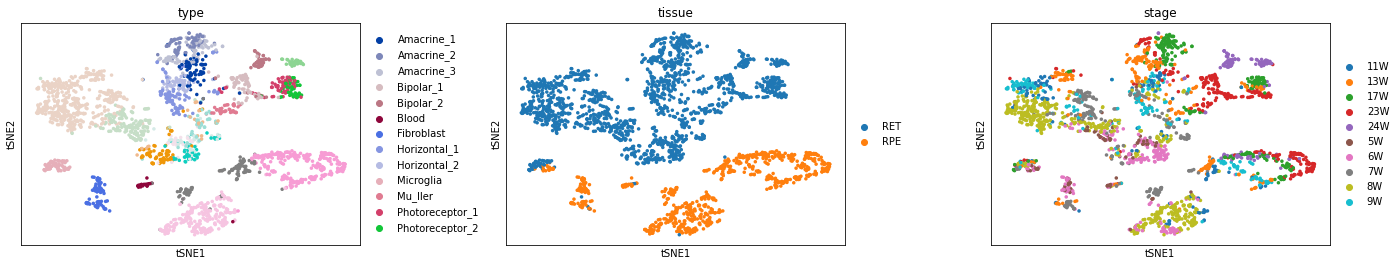

In [13]:
sc.pl.tsne(HuTang_adata_filter, color=["type", "tissue", "stage"], ncols=3, wspace=0.3)

In [14]:
HuTang_adata_filter_norm = HuTang_adata_filter.copy()
sc.pp.log1p(HuTang_adata_filter_norm)

In [15]:
keep_groups = ["RPE_1", "RPE_2", "RPE_3", "RPC_1", "RPC_2", "RPC_3", "RPC_4", "RPC_5", "RPC_6"]
HuTang_adata_filter2 = HuTang_adata_filter.copy()
HuTang_adata_filter2 = HuTang_adata_filter2[HuTang_adata_filter2.obs["type"].isin(keep_groups)]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
keep_groups2 = []
for i, j in zip(HuTang_adata_filter2.obs["type"], HuTang_adata_filter2.obs["stage"]):
    if i in ["RPC_1", "RPC_2", "RPC_3", "RPC_4", "RPC_5", "RPC_6"]:
        if j in ["5W", "6W"]:
            keep_groups2.append(True)
        else:
            keep_groups2.append(False)
    else:
        keep_groups2.append(True)

In [17]:
HuTang_adata_filter2 = HuTang_adata_filter2[keep_groups2].copy()

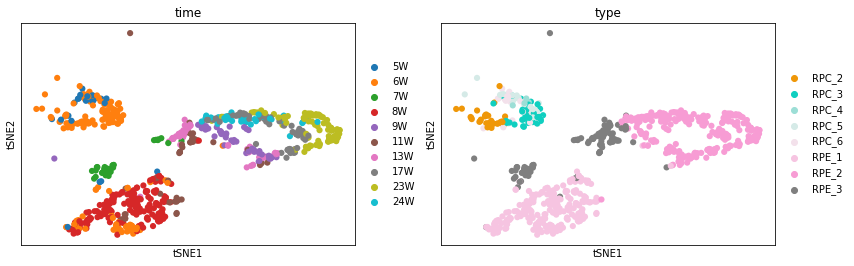

In [18]:
sc.pl.tsne(HuTang_adata_filter2, color=["time", "type"])

### Load Embyronic Eyes W5 and W7.5

In [19]:
fetalW5adata_raw = sc.read_h5ad("HumanEmbryonicEye_W5_CS13_Annotated.h5ad")
fetalW7adata_raw = sc.read_h5ad("HumanEmbryonicEye_W7_5_Annotated.h5ad")

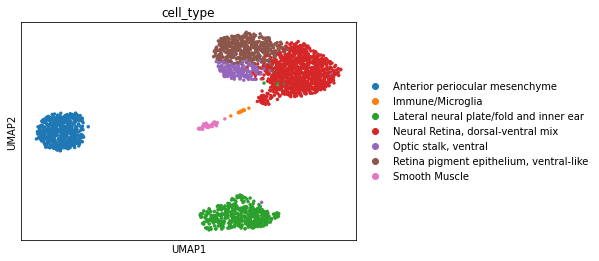

In [20]:
sc.pl.umap(fetalW5adata_raw, color=["cell_type"])

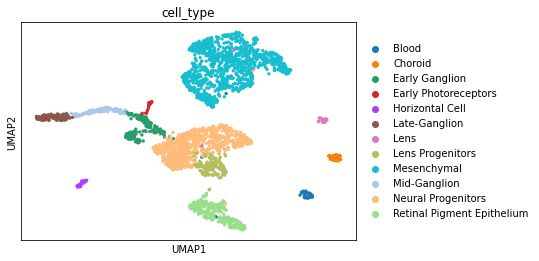

In [21]:
sc.pl.umap(fetalW7adata_raw, color=["cell_type"])

In [22]:
fetalW7adata_raw_with_blood = fetalW7adata_raw.copy()
fetalW7adata_raw = fetalW7adata_raw[fetalW7adata_raw.obs["cell_type"]!="Blood"].copy()

In [23]:
cluster_df = pd.DataFrame(fetalW7adata_raw_with_blood.X.T)
cluster_df.index = fetalW7adata_raw_with_blood.var.index
cluster_df.columns = fetalW7adata_raw_with_blood.obs["cell_type"]

In [24]:
fetalW7adata_raw_with_blood = fetalW7adata_raw_with_blood[:, np.sum(cluster_df.groupby(cluster_df.columns, axis=1).mean()>0.5, axis=1)>0]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [25]:
from miscalg import enrichment
Xgen = fetalW7adata_raw_with_blood.X.T
cluster_labels_p, names = fetalW7adata_raw_with_blood.obs["cell_type"].factorize()
enrichment_score = enrichment.enrichment_score(Xgen, cluster_labels_p)

emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(fetalW7adata_raw_with_blood.var.index), n_enriched=50)

/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [26]:
emarkers.T[np.where(names=="Blood")[0][0], :]

array(['AC104389.5', 'HBA1', 'HBB', 'HBA2', 'HBZ', 'HBM', 'AHSP', 'ALAS2',
       'HBG1', 'HEMGN', 'GYPA', 'GYPB', 'SLC4A1', 'AC104389.4', 'HBQ1',
       'KLF1', 'EPB42', 'MT1G', 'MT1H', 'HBG2', 'RHAG', 'LYL1', 'TAL1',
       'TENT5C', 'KRT1', 'PHOSPHO1', 'TRIM58', 'AC130456.3', 'SPTA1',
       'TMOD1', 'YPEL4', 'AC024267.1', 'SMIM5', 'GDF15', 'MYL4',
       'C17orf99', 'PLEK2', 'NFE2', 'RHCE', 'TUBA4A', 'TSPO2', 'GMPR',
       'CR1L', 'TESC', 'HBE1', 'SLC25A37', 'DMTN', 'GYPE', 'TMCC2',
       'FECH'], dtype=object)

In [27]:
blood_enriched_genes = np.array(emarkers.T[np.where(names=="Blood")[0][0], :])

In [28]:
sc.pp.normalize_total(fetalW7adata_raw_with_blood)
sc.pp.log1p(fetalW7adata_raw_with_blood)

/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


### Load Adult Eye

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


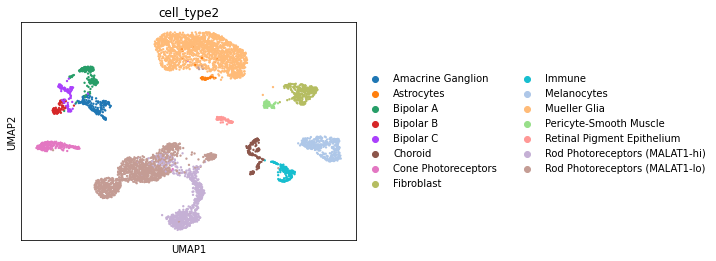

In [29]:
adult_adata = sc.read_h5ad("AdultEye_Annotated.h5ad")
adult_adata = adult_adata[~adult_adata.obs["cell_type2"].isin(["Unk", "Unk2"])].copy()
sc.pl.umap(adult_adata, color=["cell_type2"])

In [30]:
adult_adata.obs["cell_type2"].value_counts()

Mueller Glia                      1608
Rod Photoreceptors (MALAT1-lo)    1321
Rod Photoreceptors (MALAT1-hi)     747
Melanocytes                        363
Fibroblast                         267
Cone Photoreceptors                218
Amacrine Ganglion                  180
Bipolar A                          169
Choroid                            161
Immune                             136
Bipolar C                          111
Bipolar B                           84
Retinal Pigment Epithelium          71
Pericyte-Smooth Muscle              60
Astrocytes                          38
Name: cell_type2, dtype: int64

In [31]:
adult_normal_RPEs = sc.read_h5ad("true_RPEs_adata_normal.h5ad")

### Load in vivo RPEs

In [32]:
in_vivo_adata = sc.read_h5ad("InVivo_HS980.h5ad")

## Filtering based on shared genes

In [33]:
shared_genes = list(set(HuTang_adata_filter2.var.index) & set(in_vivo_adata.var.index)
                    & set(fetalW5adata_raw.var.index) 
                    & set(fetalW7adata_raw.var.index)
                    & set(adult_normal_RPEs.var.index) 
                    & set(ALL_DATA.var.index))

In [34]:
# In Vivo RPE differentiation
in_vivo_adata_raw = in_vivo_adata[:, shared_genes].copy()
in_vivo_adata_raw.shape

(65, 21810)

In [35]:
# HuTang data
HuTang_adata_raw = HuTang_adata_filter2[:, shared_genes].copy()
HuTang_adata_raw.shape

(783, 21810)

In [36]:
fetalW5adata_raw.var_names_make_unique()
fetalW5_RPE_adata_raw = fetalW5adata_raw[:, shared_genes].copy()
fetalW5_RPE_adata_raw = fetalW5_RPE_adata_raw[fetalW5_RPE_adata_raw.obs["cell_type2"]=='ONE'].copy()
fetalW5_RPE_adata_raw.shape

(1587, 21810)

In [37]:
adult_adata_raw = adult_adata[:, shared_genes].copy()
adult_adata_raw = adult_adata_raw[adult_adata_raw.obs["cell_type2"]=='Retinal Pigment Epithelium'].copy()
adult_adata_raw.shape

(71, 21810)

In [38]:
adult_adata_raw = adult_adata[:, shared_genes].copy()
adult_adata_raw.shape

(5534, 21810)

In [39]:
adult_normal_RPEs_raw = adult_normal_RPEs[:, shared_genes].copy()
adult_normal_RPEs_raw.shape

(127, 21810)

In [40]:
# HuTang data
HuTang_adata_raw = HuTang_adata_filter2[:, shared_genes].copy()
HuTang_adata_raw.shape

(783, 21810)

In [41]:
ALL_DATA = ALL_DATA[:, shared_genes].copy()

In [42]:
fetalW5adata_raw.var_names_make_unique()
fetalW5_RPE_adata_raw = fetalW5adata_raw[:, shared_genes].copy()
fetalW5_RPE_adata_raw = fetalW5_RPE_adata_raw[fetalW5_RPE_adata_raw.obs["cell_type2"]=='ONE'].copy()
fetalW5_RPE_adata_raw.shape

fetalW7adata_raw.var_names_make_unique()
fetalW7_RPE_adata_raw = fetalW7adata_raw[:, shared_genes].copy()
fetalW7_RPE_adata_raw = fetalW7_RPE_adata_raw[fetalW7_RPE_adata_raw.obs["cell_type"]=='Retinal Pigment Epithelium'].copy()
fetalW7_RPE_adata_raw.shape

(258, 21810)

### Get them both in same gene space, normalize

In [43]:
in_vivo_adata_norm = in_vivo_adata_raw.copy()
HuTang_adata_norm = HuTang_adata_raw.copy()
fetalW5_RPE_adata_norm = fetalW5_RPE_adata_raw.copy()
fetalW7_RPE_adata_norm= fetalW7_RPE_adata_raw.copy()
adult_adata_norm = adult_adata_raw.copy()
adult_normal_RPEs_norm = adult_normal_RPEs_raw.copy()
ALL_DATA_norm = ALL_DATA.copy()

In [44]:
sc.pp.normalize_total(in_vivo_adata_norm, target_sum=1000000)
sc.pp.normalize_total(fetalW5_RPE_adata_norm, target_sum=1000000)
sc.pp.normalize_total(fetalW7_RPE_adata_norm, target_sum=1000000)
sc.pp.normalize_total(adult_adata_norm, target_sum=1000000)
sc.pp.normalize_total(ALL_DATA_norm, target_sum=1000000)
sc.pp.normalize_total(adult_normal_RPEs_norm, target_sum=1000000)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [45]:
sc.pp.log1p(HuTang_adata_norm)
sc.pp.log1p(in_vivo_adata_norm)
sc.pp.log1p(fetalW5_RPE_adata_norm)
sc.pp.log1p(fetalW7_RPE_adata_norm)
sc.pp.log1p(adult_adata_norm)
sc.pp.log1p(ALL_DATA_norm)
sc.pp.log1p(adult_normal_RPEs_norm)

In [46]:
time2stage = {'9W':"Mid2", '11W':"Mid2", '13W': "Mid2",
              '17W':"Late", '23W':"Late", '24W':"Late", 
              '5W':"Early", '6W':"Early", 
              '7W':"Mid1", '8W':"Mid1",
              "RET":"RET"}

y = []
for i, j, k in zip(HuTang_adata_norm.obs["time"], HuTang_adata_norm.obs["tissue"], HuTang_adata_norm.obs["type"]):
    if time2stage[i] != "RET":
        y.append(time2stage[i]+"_"+j)
    else:
        y.append("RET_PROG")
y = np.array(y)

HuTang_adata_norm.obs["classifier_category"] = y
adult_normal_RPEs_norm.obs["classifier_category"] = "Adult"

In [47]:
all_training_data = HuTang_adata_norm.concatenate([adult_normal_RPEs_norm])

In [48]:
keep_cats = ["Early_RET", "Late_RPE", "Mid1_RPE", "Mid2_RPE", "Early_RPE", "Adult"]
all_training_data = all_training_data[all_training_data.obs["classifier_category"].isin(keep_cats)]

In [49]:
Counter(all_training_data.obs["classifier_category"])

Counter({'Mid2_RPE': 148,
         'Late_RPE': 219,
         'Mid1_RPE': 221,
         'Early_RET': 134,
         'Early_RPE': 58,
         'Adult': 127})

### Gene filtering for training dataset and label annotation

In [50]:
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected, cv_mean_score

In [51]:
cluster_df = pd.DataFrame(np.hstack([all_training_data.X.toarray().T]))
cluster_df.index = all_training_data.var.index
cluster_df.columns = all_training_data.obs["classifier_category"]
cluster_df = cluster_df.groupby(cluster_df.columns, axis=1).mean()

In [52]:
all_training_data_filt = all_training_data[:, np.array((cluster_df>1).sum(1)>0)]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [53]:
blood_enriched_genes

array(['AC104389.5', 'HBA1', 'HBB', 'HBA2', 'HBZ', 'HBM', 'AHSP', 'ALAS2',
       'HBG1', 'HEMGN', 'GYPA', 'GYPB', 'SLC4A1', 'AC104389.4', 'HBQ1',
       'KLF1', 'EPB42', 'MT1G', 'MT1H', 'HBG2', 'RHAG', 'LYL1', 'TAL1',
       'TENT5C', 'KRT1', 'PHOSPHO1', 'TRIM58', 'AC130456.3', 'SPTA1',
       'TMOD1', 'YPEL4', 'AC024267.1', 'SMIM5', 'GDF15', 'MYL4',
       'C17orf99', 'PLEK2', 'NFE2', 'RHCE', 'TUBA4A', 'TSPO2', 'GMPR',
       'CR1L', 'TESC', 'HBE1', 'SLC25A37', 'DMTN', 'GYPE', 'TMCC2',
       'FECH'], dtype=object)

In [54]:
all_training_data_filt = all_training_data_filt[:, [i not in blood_enriched_genes for i in all_training_data_filt.var.index]]
all_training_data_filt = all_training_data_filt[:, ["MT-" not in i for i in all_training_data_filt.var.index]]

In [55]:
all_training_data_filt

View of AnnData object with n_obs × n_vars = 907 × 8754
    obs: 'time', 'type', 'Unnamed: 0', 'PC1', 'PC2', 'group', 'tissue', 'stage', 'idxOrder', 'classifier_category', 'batch', 'cell_barcode', 'sample', 'bc'
    var: 'feature_types-1', 'gene_ids-1'

### Remove similar genes between opposite ends of the classifier (i.e. RetProg/EarlyRPE (w5-6) and Adult)

In [56]:
all_training_data_filt.obs["classifier_category"].value_counts()

Mid1_RPE     221
Late_RPE     219
Mid2_RPE     148
Early_RET    134
Adult        127
Early_RPE     58
Name: classifier_category, dtype: int64

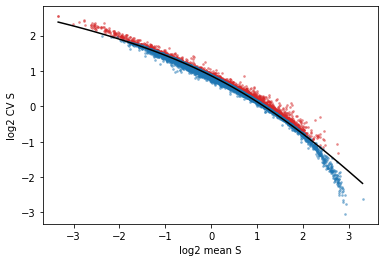

In [57]:
cv_vs_mean_keep = filter_cv_vs_mean(all_training_data_filt.X.toarray().T, N=2000, max_expr_avg=50)

In [58]:
hv_genes = np.array(all_training_data_filt[:, cv_vs_mean_keep[0]].var.index)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [59]:
len(hv_genes)

2001

# Visualize HuTang dataset

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neighbors import NearestNeighbors

In [61]:
from miscalg import enrichment
Xgen = all_training_data_filt.X.toarray().T
cluster_labels_p, names = all_training_data_filt.obs["classifier_category"].factorize()
enrichment_score = enrichment.enrichment_score(Xgen, cluster_labels_p)

emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(all_training_data_filt.var.index), n_enriched=300)

In [62]:
all_training_data_filt = all_training_data_filt[:, hv_genes].copy()
all_training_data_filt = all_training_data_filt[list(all_training_data_filt.obs.sample(all_training_data_filt.shape[0]).index), :].copy()
X = all_training_data_filt.X.toarray()

In [63]:
all_training_data_filt.obs["time"] = [i if j=="RPE" else "RET" for i,j in zip(all_training_data_filt.obs["time"], all_training_data_filt.obs["tissue"])]

In [64]:
Counter(all_training_data_filt.obs["classifier_category"])

Counter({'Mid1_RPE': 221,
         'Late_RPE': 219,
         'Early_RET': 134,
         'Adult': 127,
         'Mid2_RPE': 148,
         'Early_RPE': 58})

In [65]:
X = all_training_data_filt.X.toarray()
X.shape

(907, 2001)

In [66]:
all_training_data_filt.obs["classifier_category"] = ["RET_PROG" if i=="Early_RET" else i for i in all_training_data_filt.obs["classifier_category"]]

In [67]:
y = np.array(all_training_data_filt.obs["classifier_category"])
Counter(y)

Counter({'Mid1_RPE': 221,
         'Late_RPE': 219,
         'RET_PROG': 134,
         'Adult': 127,
         'Mid2_RPE': 148,
         'Early_RPE': 58})

# Define and train the classifier

In [68]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone


class OrdinalClassifier(ClassifierMixin, BaseEstimator):
    """It implements a versitile naive ordinal classifier.
    This implementation is based on:
    
    Eibe Frank and Mark Hal, lECML 2001. 12th European Conference)
    https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf
    
    Parameters
    ----------
    classifier_type: ClassifierMixin
        An instantiatied classifier object.
        For example `LogisticRegressionCV`.
        
    ordered_labels: Optional, Iterable
        The order of the labels to be imposed as a list or np.ndarray
        It can be omitted if labels are already integers with no-gaps encoding the order.
    
    verbose: bool, default=True
        Whether to print output during the fit
    
    Attributes
    ----------
    classifiers: List[ClassifierMixin]
        A list of the binary classifiers for the ordered bisections.
    
    classifier_type: ClassifierMixin
        The generic of classifier instance used for each of the binary classifiers.
    
    
    Example
    -------
    ```
    clf = LogisticRegressionCV(Cs=35, penalty='l1', solver="liblinear", fit_intercept=False, max_iter=500, cv=6)
    ord_clf = OrdinalClassifier(clf, ordered_labels=['label_early',  'label_mid', 'label_late', 'label_verylater'])
    ord_clf.fit(X_train, y_train)
    probabilites = ord_clf.predict_proba(X)
    predicted_labels = ord_clf.predict(X)
    
    ```
    """
    def __init__(self, classifier_type, ordered_labels = None, verbose = False):
        self.classifier_type = classifier_type
        self.ordered_labels = np.array(ordered_labels) if ordered_labels else ordered_labels
        self.verbose = verbose
        self._ordered_dict = None
        self._n_classes = None
        self.classifiers = None
    
    @property
    def classes_(self):
        return self.ordered_labels
    
    def fit(self, X, y):
        """Fit the model according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like of shape (n_samples,)
            Target vector relative to X.

        Returns
        -------
        self : object
        """
        uq_labels = np.unique(y)
        self._n_classes = len(uq_labels)
        self.classifiers = [clone(self.classifier_type) for i in range(self._n_classes - 1)]
        
        if self.ordered_labels is None:
            self.ordered_labels = np.arange(self._n_classes)
        
        p = set(self.ordered_labels)
        assert not (p ^ set(uq_labels)), f"Found the label/s: {p} for which no order was specified"
        self._ordered_dict = dict(zip(self.ordered_labels, np.arange(self._n_classes)))
        self._rev_ordered_dict = {v:k for k, v in self._ordered_dict.items()}
        y_ordered = np.array([self._ordered_dict[i] for i in y])
    
        for i in range(1, self._n_classes):
            if self.verbose:
                print(f"Fitting bisection between {self.classes_[:i]} and {set(self.classes_) - set(self.classes_[:i])}")
            y_bin = (y_ordered >= i).astype(int)
            self.classifiers[i-1].fit(X, y_bin)
        return self
    
    def predict(self, X):
        """Predict class labels for samples in X.

        Parameters
        ----------
        X : array_like or sparse matrix, shape (n_samples, n_features)
            Samples.

        Returns
        -------
        C : array, shape [n_samples]
            Predicted class label per sample.
        """
        probabilities = self.predict_proba(X)
        predicted_labels = probabilities.argmax(1)
        predicted_labels_names = self.ordered_labels[predicted_labels]
        return predicted_labels_names
    
    def predict_proba(self, X):
            """Probability estimates.

            Parameters
            ----------
            X : array-like of shape (n_samples, n_features)
                Vector to be scored, where `n_samples` is the number of samples and
                `n_features` is the number of features.

            Returns
            -------
            T : array-like of shape (n_samples, n_classes)
                Returns the probability of the sample for each class in the model,
                where classes are ordered as they are in ``self.classes_``.
            """
            P_tmp = np.zeros((X.shape[0], self._n_classes+1))
            P_tmp[:, 0] = 1
            for i in range(1, self._n_classes):
                clf = self.classifiers[i-1]
                bin_prob = clf.predict_proba(X)
                ix_lbl_of_1 = np.where(clf.classes_ == 1)[0][0]
                P_tmp[:, i] = bin_prob[:, ix_lbl_of_1]
            probabilities = P_tmp[:, :-1] - P_tmp[:, 1:]
            #patch
            probabilities = np.clip(probabilities, 0, 1)
            probabilities = probabilities / probabilities.sum(1)[:, None]
            return probabilities
        

In [69]:
all_training_data_filt_final = all_training_data_filt.copy()

In [70]:
X = all_training_data_filt_final.X.toarray()
all_training_data_filt_final.obs["classifier_category"] = ["RET_PROG" if i=="Early_RET" else i for i in all_training_data_filt_final.obs["classifier_category"]]
y = np.array(all_training_data_filt_final.obs["classifier_category"])

In [71]:
clf = LogisticRegression(C=5, penalty='l1', solver="liblinear", fit_intercept=False, max_iter=500)
labels = ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult']#, "Diseased"]
ord_clf = OrdinalClassifier(clf, ordered_labels=labels, verbose=True)
ord_clf = ord_clf.fit(X, y)

Fitting bisection between ['RET_PROG'] and {'Mid2_RPE', 'Early_RPE', 'Late_RPE', 'Mid1_RPE', 'Adult'}
Fitting bisection between ['RET_PROG' 'Early_RPE'] and {'Mid2_RPE', 'Mid1_RPE', 'Adult', 'Late_RPE'}
Fitting bisection between ['RET_PROG' 'Early_RPE' 'Mid1_RPE'] and {'Mid2_RPE', 'Adult', 'Late_RPE'}
Fitting bisection between ['RET_PROG' 'Early_RPE' 'Mid1_RPE' 'Mid2_RPE'] and {'Adult', 'Late_RPE'}
Fitting bisection between ['RET_PROG' 'Early_RPE' 'Mid1_RPE' 'Mid2_RPE' 'Late_RPE'] and {'Adult'}


In [72]:
ord_clf.features = np.array(HuTang_adata_norm.var.index)

In [73]:
# Accuracy on training data
np.sum(ord_clf.predict(X) == y)/ len(y)

1.0

# Take relevant cells from the in vitro timecourse and classify them!

In [74]:
keep = ['EMT-RPE', 'EarlyRPE', 'MidRPE', 'LateRPE', 'RetProg']
ALL_DATA_norm2 = ALL_DATA_norm[ALL_DATA_norm.obs["CELLTYPE1"].isin(keep)].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [75]:
ALL_DATA_norm2

AnnData object with n_obs × n_vars = 20863 × 21810
    obs: 'INDIVIDUAL_UMAP1', 'INDIVIDUAL_UMAP2', 'CELL_LINE', 'DAY', 'CELLTYPE1', 'CELLTYPE2', 'BARCODE', 'DAY_INTEGRATED_UMAP1', 'DAY_INTEGRATED_UMAP2', 'batch'
    var: 'Accession', 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'log1p'

In [76]:
ALL_DATA_norm_X = ALL_DATA_norm2[:, hv_genes].X
final_prob = ord_clf.predict_proba(ALL_DATA_norm_X.toarray())
final_class = ord_clf.predict(ALL_DATA_norm_X.toarray())

In [77]:
print(Counter(final_class))

Counter({'Mid2_RPE': 8030, 'Mid1_RPE': 5929, 'Early_RPE': 3641, 'RET_PROG': 2171, 'Late_RPE': 553, 'Adult': 539})


In [78]:
import pickle

In [79]:
plt.rcParams["pdf.fonttype"] = 42 

Counter({3.0: 7217, 2.0: 6549, 1.0: 3448, 4.0: 2222, 0.0: 1328, 5.0: 99})


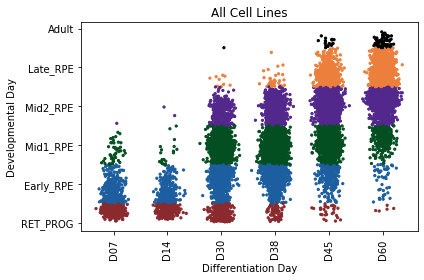

In [80]:
final_prob2 = final_prob.copy() 
final_class2 = final_class.copy()

estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = final_prob2.dot(np.array(estimated_ages))
final_prob_date_assignment_all2 = np.round(final_prob_date_assignment_all)

print(Counter(np.round(final_prob_date_assignment_all2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_all2)]

day_numeric = np.array([i for i in ALL_DATA_norm2.obs["DAY"]])
len(day_numeric)

differentiation_days_key = np.array(["D07", "D14", "D30", "D38", "D45", "D60"])
developmental_days_key = np.array(['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
day2pos = {"D7":0, "D14":1, "D30":2, "D38":3, "D45":4, "D60":5}
v2 = list(final_prob_date_assignment_all)
d2 = list(day_numeric)
d2 = [day2pos[i] for i in d2]
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5, c=colors, rasterized=True)
plt.xlabel("Differentiation Day")
plt.ylabel("Developmental Day")
plt.xticks([i for i in range(0, len(differentiation_days_key))], differentiation_days_key, rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0)
plt.title("All Cell Lines")
plt.tight_layout()
plt.show()

In [81]:
# Create a data dictionary to store all resulting predictions

data = {}
days = ALL_DATA_norm2.obs["DAY"]
cell_lines = ALL_DATA_norm2.obs["CELL_LINE"]

data["D7_ALL"] = final_prob_date_assignment_all[days=="D7"]
data["D14_ALL"] = final_prob_date_assignment_all[days=="D14"]
data["D30_ALL"] = final_prob_date_assignment_all[days=="D30"]
data["D38_ALL"] = final_prob_date_assignment_all[days=="D38"]
data["D45_ALL"] = final_prob_date_assignment_all[days=="D45"]
data["D60_ALL"] = final_prob_date_assignment_all[days=="D60"]

Counter({2.0: 3506, 3.0: 1609, 1.0: 1459, 0.0: 724, 4.0: 274})


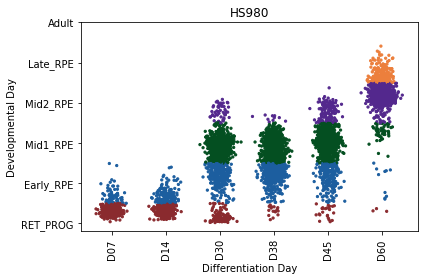

In [82]:
cell_line = "HS980"
final_prob2 = final_prob[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
final_class2 = final_class[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]

estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = final_prob2.dot(np.array(estimated_ages))
final_prob_date_assignment_all2 = np.round(final_prob_date_assignment_all)

print(Counter(np.round(final_prob_date_assignment_all2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_all2)]

day_numeric = np.array([i for i in ALL_DATA_norm2.obs["DAY"]])[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
len(day_numeric)

differentiation_days_key = np.array(["D07", "D14", "D30", "D38", "D45", "D60"])
developmental_days_key = np.array(['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
day2pos = {"D7":0, "D14":1, "D30":2, "D38":3, "D45":4, "D60":5}
v2 = list(final_prob_date_assignment_all)
d2 = list(day_numeric)
d2 = [day2pos[i] for i in d2]
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5, c=colors, rasterized=True)
plt.xlabel("Differentiation Day")
plt.ylabel("Developmental Day")
plt.xticks([i for i in range(0, len(differentiation_days_key))], differentiation_days_key, rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0)
plt.title(cell_line)
plt.tight_layout()
plt.show()

In [83]:
hs980_days = ALL_DATA_norm2[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line].obs["DAY"]
data["D7_HS980"] = final_prob_date_assignment_all[hs980_days=="D7"]
data["D14_HS980"] = final_prob_date_assignment_all[hs980_days=="D14"]
data["D30_HS980"] = final_prob_date_assignment_all[hs980_days=="D30"]
data["D38_HS980"] = final_prob_date_assignment_all[hs980_days=="D38"]
data["D45_HS980"] = final_prob_date_assignment_all[hs980_days=="D45"]
data["D60_HS980"] = final_prob_date_assignment_all[hs980_days=="D60"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Counter({3.0: 2020, 4.0: 1478, 2.0: 1304, 1.0: 818, 0.0: 172, 5.0: 97})


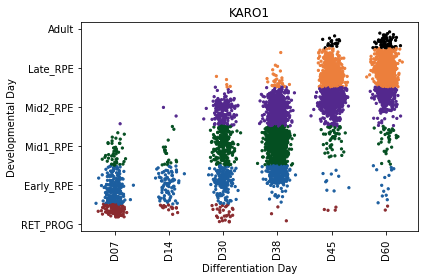

In [84]:
cell_line = "KARO1"
final_prob2 = final_prob[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
final_class2 = final_class[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]

estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = final_prob2.dot(np.array(estimated_ages))
final_prob_date_assignment_all2 = np.round(final_prob_date_assignment_all)

print(Counter(np.round(final_prob_date_assignment_all2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_all2)]

day_numeric = np.array([i for i in ALL_DATA_norm2.obs["DAY"]])[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
len(day_numeric)

differentiation_days_key = np.array(["D07", "D14", "D30", "D38", "D45", "D60"])
developmental_days_key = np.array(['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
day2pos = {"D7":0, "D14":1, "D30":2, "D38":3, "D45":4, "D60":5}
v2 = list(final_prob_date_assignment_all)
d2 = list(day_numeric)
d2 = [day2pos[i] for i in d2]
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5, c=colors,rasterized=True)
plt.xlabel("Differentiation Day")
plt.ylabel("Developmental Day")
plt.xticks([i for i in range(0, len(differentiation_days_key))], differentiation_days_key, rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0)
plt.title(cell_line)
plt.tight_layout()
plt.show()

In [85]:
karo1_days = ALL_DATA_norm2[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line].obs["DAY"]
data["D7_KARO1"] = final_prob_date_assignment_all[karo1_days=="D7"]
data["D14_KARO1"] = final_prob_date_assignment_all[karo1_days=="D14"]
data["D30_KARO1"] = final_prob_date_assignment_all[karo1_days=="D30"]
data["D38_KARO1"] = final_prob_date_assignment_all[karo1_days=="D38"]
data["D45_KARO1"] = final_prob_date_assignment_all[karo1_days=="D45"]
data["D60_KARO1"] = final_prob_date_assignment_all[karo1_days=="D60"]

Counter({3.0: 3588, 2.0: 1739, 1.0: 1171, 4.0: 470, 0.0: 432, 5.0: 2})


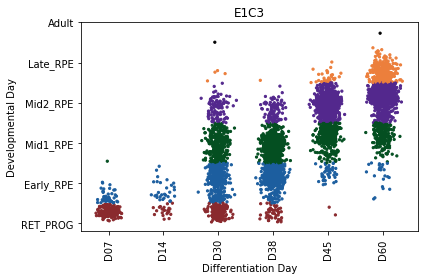

In [86]:
cell_line = "E1C3"
final_prob2 = final_prob[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
final_class2 = final_class[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]

estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = final_prob2.dot(np.array(estimated_ages))
final_prob_date_assignment_all2 = np.round(final_prob_date_assignment_all)

print(Counter(np.round(final_prob_date_assignment_all2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_all2)]

day_numeric = np.array([i for i in ALL_DATA_norm2.obs["DAY"]])[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line]
len(day_numeric)

differentiation_days_key = np.array(["D07", "D14", "D30", "D38", "D45", "D60"])
developmental_days_key = np.array(['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
day2pos = {"D7":0, "D14":1, "D30":2, "D38":3, "D45":4, "D60":5}
v2 = list(final_prob_date_assignment_all)
d2 = list(day_numeric)
d2 = [day2pos[i] for i in d2]
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5, c=colors,rasterized=True)
plt.xlabel("Differentiation Day")
plt.ylabel("Developmental Day")
plt.xticks([i for i in range(0, len(differentiation_days_key))], differentiation_days_key, rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0)
plt.title(cell_line)
plt.tight_layout()
plt.show()

In [87]:
e1c3_days = ALL_DATA_norm2[ALL_DATA_norm2.obs["CELL_LINE"]==cell_line].obs["DAY"]
data["D7_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D7"]
data["D14_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D14"]
data["D30_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D30"]
data["D38_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D38"]
data["D45_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D45"]
data["D60_E1C3"] = final_prob_date_assignment_all[e1c3_days=="D60"]

In [88]:
data.keys()

dict_keys(['D7_ALL', 'D14_ALL', 'D30_ALL', 'D38_ALL', 'D45_ALL', 'D60_ALL', 'D7_HS980', 'D14_HS980', 'D30_HS980', 'D38_HS980', 'D45_HS980', 'D60_HS980', 'D7_KARO1', 'D14_KARO1', 'D30_KARO1', 'D38_KARO1', 'D45_KARO1', 'D60_KARO1', 'D7_E1C3', 'D14_E1C3', 'D30_E1C3', 'D38_E1C3', 'D45_E1C3', 'D60_E1C3'])

In [89]:
vivo_norm_X = in_vivo_adata_norm[:, hv_genes].X
vivo_final_prob = ord_clf.predict_proba(vivo_norm_X.toarray())
vivo_final_class = ord_clf.predict(vivo_norm_X.toarray())
Counter(vivo_final_class)

Counter({'Mid2_RPE': 18, 'Late_RPE': 19, 'Adult': 21, 'Mid1_RPE': 7})

In [90]:
estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = vivo_final_prob.dot(np.array(estimated_ages))

In [91]:
data["Vivo"] = final_prob_date_assignment_all

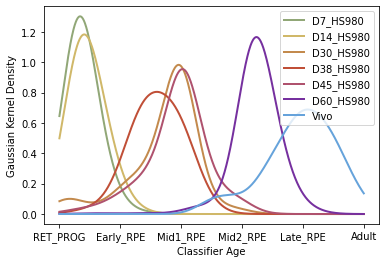

In [92]:
from sklearn.neighbors import KernelDensity

samples = ["D7_HS980", "D14_HS980", "D30_HS980", "D38_HS980", "D45_HS980", "D60_HS980", "Vivo"]

n2c = {"D7_HS980":"#91a777", "D14_HS980":"#D0B869", "D30_HS980":"#C38A4D", 
       "D38_HS980":"#C04F37", "D45_HS980":"#AF526E", "D60_HS980":"#76309F",
      "Vivo":"#66A3DB"}
kernel = "gaussian"
lw = 2

# Plot a 1D density example
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

In [93]:
x = [np.sum(np.abs(ord_clf.classifiers[i].coef_) > 0.05) for i in range(0, len(ord_clf.classifiers))]

In [94]:
ixs = np.argsort(np.abs(ord_clf.classifiers[0].coef_)[0])[::-1]
HuTang_adata_norm[:, hv_genes].var.index[ixs][:x[0]]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Index(['CRYAA', 'SERPINF1', 'SFRP2', 'SOX2', 'PTGDS', 'SIX6', 'TRPM1', 'DCT',
       'WNT2B', 'TTR', 'PMEL', 'MEST', 'KIF21A', 'PCP4', 'IGFBP5', 'FRZB',
       'LGALS1', 'TFPI2', 'SHISA2', 'APOE', 'ELN', 'COL2A1', 'TYRP1', 'RHOC',
       'SFRP5', 'PCDH7', 'CPAMD8', 'TIMP3', 'CKS2', 'DHRS3', 'GNG11', 'SNRPD1',
       'COL1A2'],
      dtype='object')

In [95]:
ixs = np.argsort(np.abs(ord_clf.classifiers[1].coef_)[0])[::-1]
HuTang_adata_norm[:, hv_genes].var.index[ixs][:x[0]]

Index(['TTR', 'HIF3A', 'ANXA1', 'CRYAB', 'ATP6V1B1', 'MMRN1', 'MLANA', 'PCP4',
       'RHOB', 'ZFP36', 'RHOC', 'MSX1', 'CDH6', 'PTGDS', 'SLIT2', 'LGALS3BP',
       'SLC30A8', 'GNG11', 'MRPL36', 'ATP1B1', 'CYTL1', 'ELN', 'PCDH7',
       'CRABP2', 'ZWINT', 'RPS4Y1', 'DDX56', 'MARCKSL1', 'EGR1', 'KDM1A',
       'FBN2', 'HMGA2', 'COL2A1'],
      dtype='object')

In [96]:
ixs = np.argsort(np.abs(ord_clf.classifiers[2].coef_)[0])[::-1]
HuTang_adata_norm[:, hv_genes].var.index[ixs][:x[0]]

Index(['IGKC', 'IGHA2', 'TTR', 'NPFFR1', 'SLC38A8', 'IGHA1', 'ADAD2', 'BEST1',
       'RLBP1', 'CRABP2', 'COL3A1', 'RPE65', 'PTGDS', 'SLC38A1', 'OGN',
       'COL1A1', 'ID1', 'ZC3H15', 'PLEKHB1', 'NUPR1', 'CRYAB', 'PGM5-AS1',
       'FIGN', 'MYH11', 'DBN1', 'ID3', 'RGS16', 'ZNF43', 'HSPA1B', 'NR2F1',
       'SLC16A8', 'HMGA2', 'TTLL4'],
      dtype='object')

In [97]:
ixs = np.argsort(np.abs(ord_clf.classifiers[3].coef_)[0])[::-1]
HuTang_adata_norm[:, hv_genes].var.index[ixs][:x[0]]

Index(['COL3A1', 'TERT', 'RNASE1', 'NFASC', 'LINC00645', 'COL1A2', 'DCT',
       'CCT7', 'ERMN', 'C1orf61', 'SLC16A3', 'FZD8', 'MYRF', 'ELN', 'COL1A1',
       'MT1F', 'SLC22A8', 'TUBB2B', 'NNAT', 'NFIX', 'HSD17B2', 'CD24',
       'EPB41L4A-AS1', 'NCCRP1', 'WNT2B', 'GADD45B', 'ST6GALNAC2', 'GGH',
       'UACA', 'HIGD2A', 'LRAT', 'WFDC1', 'CDH2'],
      dtype='object')

In [98]:
ixs = np.argsort(np.abs(ord_clf.classifiers[4].coef_)[0])[::-1]
HuTang_adata_norm[:, hv_genes].var.index[ixs][:x[0]]

Index(['TUBA1B', 'CRYAB', 'GAPDH', 'FHIT', 'FTH1', 'MDK', 'CRABP1', 'ELN',
       'NR4A1', 'DYNC1I2', 'MAP1B', 'PRDX1', 'CRISPLD1', 'RELN', 'ANXA2',
       'IGFBP5', 'EIF4A1', 'TUBA1C', 'PMEL', 'TYR', 'HIST1H4C', 'SMC3', 'DCT',
       'JUNB', 'CALD1', 'MARCKS', 'WFDC1', 'MKNK2', 'FGFR3', 'NBPF14', 'MGP',
       'TMSB15A', 'MYEF2'],
      dtype='object')

In [99]:
in_vivo_adata_norm_X = in_vivo_adata_norm[:, hv_genes].X

final_prob_vivo = ord_clf.predict_proba(in_vivo_adata_norm_X)
final_class_vivo = ord_clf.predict(in_vivo_adata_norm_X)

print(Counter(final_class_vivo))

Counter({'Adult': 21, 'Late_RPE': 19, 'Mid2_RPE': 18, 'Mid1_RPE': 7})


In [100]:
fetalW5_RPE_norm_X = fetalW5_RPE_adata_norm[:, hv_genes].X

final_prob_w5 = ord_clf.predict_proba(fetalW5_RPE_norm_X)
final_class_w5 = ord_clf.predict(fetalW5_RPE_norm_X)

print(Counter(final_class_w5))

Counter({'RET_PROG': 1572, 'Early_RPE': 10, 'Adult': 5})


In [101]:
fetalW7_RPE_norm_X = fetalW7_RPE_adata_norm[:, hv_genes].X

final_prob_w7 = ord_clf.predict_proba(fetalW7_RPE_norm_X)
final_class_w7 = ord_clf.predict(fetalW7_RPE_norm_X)

print(Counter(final_class_w7))

Counter({'Mid1_RPE': 184, 'Early_RPE': 74})


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Counter({1.0: 899, 0.0: 483, 2.0: 458, 3.0: 5})


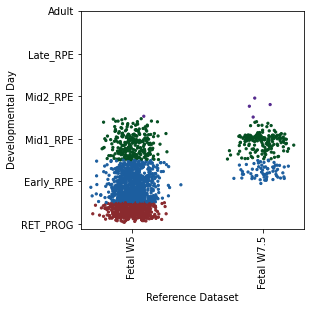

In [102]:
final_prob_all_fetal = np.vstack([final_prob_w5, final_prob_w7])

final_prob_mod_fetal = []
for i in range(0, len(final_prob_all_fetal)):
    curr_prob = final_prob_all_fetal[i, :]
    max_prob_pos = np.argmax(final_prob_all_fetal[i, :])
        
    tmp_array = []
    for i in range(0, len(curr_prob)):
        if ((i+1)==(max_prob_pos)) | ((i-1)==(max_prob_pos)) | (i==(max_prob_pos)):
            tmp_array.append(1)
        else:
            tmp_array.append(0)
    curr_prob_mod = curr_prob * np.array(tmp_array)
    final_prob_mod_fetal.append(curr_prob_mod)
final_prob_mod_fetal = np.array(final_prob_mod_fetal)


estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_fetal = final_prob_all_fetal.dot(np.array(estimated_ages))
final_prob_date_assignment_fetal2 = np.round(final_prob_date_assignment_fetal)

print(Counter(np.round(final_prob_date_assignment_fetal2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_fetal2)]


v2 = list(final_prob_date_assignment_fetal)
d2 = list([0])*len(final_prob_w5) + list([1])*len(final_prob_w7)
plt.figure(None, (4, 4))
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5,
           c=colors)
plt.xlabel("Reference Dataset")
plt.ylabel("Developmental Day")
plt.xticks([0, 1], ["Fetal W5", "Fetal W7.5"], rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0, rasterized=True)
plt.show()

In [103]:
len(final_prob_date_assignment_fetal)

1845

In [104]:
data["Embryonic_W5"] = final_prob_date_assignment_fetal[np.array(d2)==0]
data["Embryonic_W7"] = final_prob_date_assignment_fetal[np.array(d2)==1]

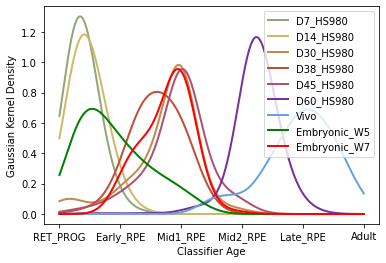

In [105]:
from sklearn.neighbors import KernelDensity

samples = ["D7_HS980", "D14_HS980", "D30_HS980", "D38_HS980", "D45_HS980", "D60_HS980", "Vivo", 
          "Embryonic_W5", "Embryonic_W7"]

n2c = {"D7_HS980":"#91a777", "D14_HS980":"#D0B869", "D30_HS980":"#C38A4D", 
       "D38_HS980":"#C04F37", "D45_HS980":"#AF526E", "D60_HS980":"#76309F",
      "Vivo":"#66A3DB", "Embryonic_W5":"green", "Embryonic_W7":"red"}
kernel = "gaussian"
lw = 2

# Plot a 1D density example
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

In [106]:
HS980_Rep2 = sc.read_h5ad("HS980_RPE60_Rep2.h5ad")

E1C3_Rep2 = sc.read_h5ad("E1C3_d60iM511.h5ad")
E1C3_Rep3 = sc.read_h5ad("E1C3_d62iM511.h5ad")
E1C3_Rep4 = sc.read_h5ad("E1C3_d62LN521.h5ad")

D60_SORTED_ALL = sc.read_h5ad("D60_Unsorted_NCAM1_CD140b_Annotated_raw2.h5ad")
HS980_Rep3 = D60_SORTED_ALL[D60_SORTED_ALL.obs["sample"]=="Unsorted"].copy()
HS980_NCAM1 = D60_SORTED_ALL[D60_SORTED_ALL.obs["sample"]=="NCAM1-High"].copy()
HS980_CD140b = D60_SORTED_ALL[D60_SORTED_ALL.obs["sample"]=="CD140b-High"].copy()

EB_Rep1 = sc.read_h5ad("EB_D60_Analysis_Raw_Annotated.h5ad")
EB_Rep1 = EB_Rep1[EB_Rep1.obs["cell_type"]=="RPE"].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [107]:
import scipy
def normalize_and_predict(currdata, hv_genes, model):
    cdata = currdata.copy()
    exl = []
    for i in hv_genes:
        if i not in cdata.var.index: 
            exl.append(i)
    print(len(exl))
    
    if type(cdata.X)==scipy.sparse.csr.csr_matrix:
        X = np.hstack([cdata.X.toarray(), np.zeros([cdata.n_obs, len(exl)])])
    else:
        X = np.hstack([cdata.X, np.zeros([cdata.n_obs, len(exl)])])

    var_tmp = cdata.var
    for i in range(0, len(exl)):
        var_tmp = var_tmp.append(var_tmp.iloc[-1])
    var_tmp.index = list(cdata.var.index) + list(exl)

    cdata2 = sc.AnnData(X)
    cdata2.obs = cdata.obs
    cdata2.var = var_tmp

    sc.pp.normalize_total(cdata2, target_sum=1000000)
    sc.pp.log1p(cdata2)
    cdata_X = cdata2[:, hv_genes].X.toarray()

    final_prob = model.predict_proba(cdata_X)
    final_class = model.predict(cdata_X)
    return final_prob, final_class

In [108]:
final_prob, final_class = normalize_and_predict(HS980_Rep2, hv_genes, ord_clf)
data["D60_HS980_Rep2"] = final_prob.dot(np.array(estimated_ages))

45


normalizing counts per cell
    finished (0:00:00)


In [109]:
HS980_Rep3 = HS980_Rep3[HS980_Rep3.obs["cell_type"].isin(['EMT RPE',
 'Early RPE',
 'Late RPE',
 'Mid RPE', 'Retinal Progenitors'])].copy()
final_prob, final_class = normalize_and_predict(HS980_Rep3, hv_genes, ord_clf)
data["D60_HS980_Rep3"] = final_prob.dot(np.array(estimated_ages))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell


0


    finished (0:00:00)


In [110]:
final_prob, final_class = normalize_and_predict(E1C3_Rep2, hv_genes, ord_clf)
data["D60_E1C3_Rep2"] = final_prob.dot(np.array(estimated_ages))

final_prob, final_class = normalize_and_predict(E1C3_Rep3, hv_genes, ord_clf)
data["D60_E1C3_Rep3"] = final_prob.dot(np.array(estimated_ages))

final_prob, final_class = normalize_and_predict(E1C3_Rep4, hv_genes, ord_clf)
data["D60_E1C3_Rep4"] = final_prob.dot(np.array(estimated_ages))

17


normalizing counts per cell
    finished (0:00:00)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


17


normalizing counts per cell
    finished (0:00:01)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


17


normalizing counts per cell
    finished (0:00:01)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [111]:
final_prob, final_class = normalize_and_predict(EB_Rep1, hv_genes, ord_clf)
data["D60_EB"] = final_prob.dot(np.array(estimated_ages))

normalizing counts per cell
    finished (0:00:00)


15


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [112]:
data.keys()

dict_keys(['D7_ALL', 'D14_ALL', 'D30_ALL', 'D38_ALL', 'D45_ALL', 'D60_ALL', 'D7_HS980', 'D14_HS980', 'D30_HS980', 'D38_HS980', 'D45_HS980', 'D60_HS980', 'D7_KARO1', 'D14_KARO1', 'D30_KARO1', 'D38_KARO1', 'D45_KARO1', 'D60_KARO1', 'D7_E1C3', 'D14_E1C3', 'D30_E1C3', 'D38_E1C3', 'D45_E1C3', 'D60_E1C3', 'Vivo', 'Embryonic_W5', 'Embryonic_W7', 'D60_HS980_Rep2', 'D60_HS980_Rep3', 'D60_E1C3_Rep2', 'D60_E1C3_Rep3', 'D60_E1C3_Rep4', 'D60_EB'])

In [113]:
samples = ["D60_HS980", "D60_HS980_Rep2", "D60_HS980_Rep3", "D60_KARO1", 
                      "D60_E1C3", "D60_E1C3_Rep2", "D60_E1C3_Rep3", "D60_E1C3_Rep4"]
data["D60_Average"] = np.hstack([data[s] for s in samples])

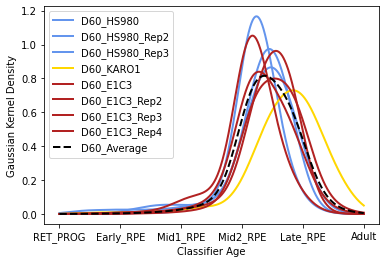

In [114]:
from sklearn.neighbors import KernelDensity

samples = ["D60_HS980", "D60_HS980_Rep2", "D60_HS980_Rep3", "D60_KARO1", 
                      "D60_E1C3", "D60_E1C3_Rep2", "D60_E1C3_Rep3", "D60_E1C3_Rep4", "D60_Average"]


n2c = {"D60_HS980":"cornflowerblue", "D60_HS980_Rep2":"cornflowerblue", "D60_HS980_Rep3":"cornflowerblue", 
       "D60_KARO1":"gold", "D60_E1C3":"firebrick", "D60_E1C3_Rep2":"firebrick", "D60_E1C3_Rep3":"firebrick", 
       "D60_E1C3_Rep4":"firebrick", "D60_Average":"black"}
kernel = "gaussian" #'gaussian', 'tophat', 'epanechnikov'
lw = 2

# Plot a 1D density example
distr_dict = {}
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    distr_dict[sample] = log_dens
    if sample=="D60_Average":
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='--', label=sample, c=n2c[sample])
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

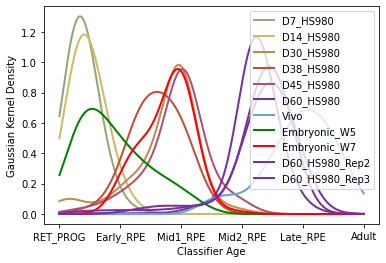

In [115]:
from sklearn.neighbors import KernelDensity

samples = ["D7_HS980", "D14_HS980", "D30_HS980", "D38_HS980", "D45_HS980", "D60_HS980", "Vivo", 
          "Embryonic_W5", "Embryonic_W7", "D60_HS980_Rep2", "D60_HS980_Rep3",]

n2c = {"D7_HS980":"#91a777", "D14_HS980":"#D0B869", "D30_HS980":"#C38A4D", 
       "D38_HS980":"#C04F37", "D45_HS980":"#AF526E", "D60_HS980":"#76309F",
      "Vivo":"#66A3DB", "Embryonic_W5":"green", "Embryonic_W7":"red", "D60_HS980_Rep2":"#76309F", "D60_HS980_Rep3":"#76309F"}
kernel = "gaussian"
lw = 2

# Plot a 1D density example
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

In [116]:
data["D60_HS980_ALL"] = np.hstack([data[s] for s in ["D60_HS980", "D60_HS980_Rep2", "D60_HS980_Rep3"]])
data["D60_E1C3_ALL"] = np.hstack([data[s] for s in ["D60_E1C3", "D60_E1C3_Rep2", "D60_E1C3_Rep3", "D60_E1C3_Rep4"]])

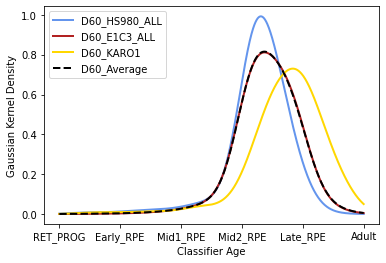

In [117]:
from sklearn.neighbors import KernelDensity

samples = ["D60_HS980_ALL", "D60_E1C3_ALL", "D60_KARO1", "D60_Average"]

n2c = {"D60_HS980_ALL":"cornflowerblue", "D60_KARO1":"gold", 
                      "D60_E1C3_ALL":"firebrick", "D60_Average":"black"}
kernel = "gaussian" #'gaussian', 'tophat', 'epanechnikov'
lw = 2

# Plot a 1D density example
distr_dict = {}
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    distr_dict[sample] = log_dens
    if sample=="D60_Average":
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='--', label=sample, c=n2c[sample])
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

In [118]:
d38_non = sc.read_h5ad("D38_NonReplated.h5ad")
d60_non = sc.read_h5ad("D60_NonReplated.h5ad")

d38_non_rpe = d38_non[d38_non.obs["cell_type"].isin(["EMT-RPE", "EarlyRPE", "MidRPE", "LateRPE"])].copy()
d60_non_rpe = d60_non[d60_non.obs["cell_type"].isin(["EMT-RPE", "EarlyRPE", "MidRPE", "LateRPE"])].copy()

fp38, fc38 = normalize_and_predict(d38_non_rpe, hv_genes, ord_clf)
fp60, fc60 = normalize_and_predict(d60_non_rpe, hv_genes, ord_clf)

final_prob_date_assignment_38non = fp38.dot(np.array(estimated_ages))
final_prob_date_assignment_60non = fp60.dot(np.array(estimated_ages))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell
    finished (0:00:00)


0


normalizing counts per cell


32


    finished (0:00:00)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [119]:
data["D38_HS980_Non"] = final_prob_date_assignment_38non
data["D60_HS980_Non"] = final_prob_date_assignment_60non

In [120]:
# D38 and D60 replated, but without the RetProg populations (ONLY the RPEs!)
ALL_DATA_norm_X = ALL_DATA_norm2[:, hv_genes].X
final_prob = ord_clf.predict_proba(ALL_DATA_norm_X.toarray())
final_class = ord_clf.predict(ALL_DATA_norm_X.toarray())

final_prob2 = final_prob.copy() 
final_class2 = final_class.copy()

estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_all = final_prob2.dot(np.array(estimated_ages))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [121]:
data["D38_HS980_RPE"] = final_prob_date_assignment_all[np.array((ALL_DATA_norm2.obs["DAY"]=="D38") & (ALL_DATA_norm2.obs["CELL_LINE"]=="HS980") & (ALL_DATA_norm2.obs["CELLTYPE1"].isin(["EMT-RPE", "EarlyRPE", "MidRPE", "LateRPE"])))]
data["D60_HS980_RPE"] = final_prob_date_assignment_all[np.array((ALL_DATA_norm2.obs["DAY"]=="D60") & (ALL_DATA_norm2.obs["CELL_LINE"]=="HS980") & (ALL_DATA_norm2.obs["CELLTYPE1"].isin(["EMT-RPE", "EarlyRPE", "MidRPE", "LateRPE"])))]

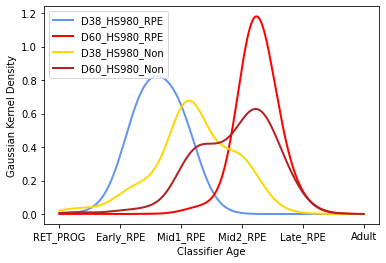

In [122]:
from sklearn.neighbors import KernelDensity


samples = ["D38_HS980_RPE", "D60_HS980_RPE", "D38_HS980_Non", "D60_HS980_Non"]

n2c = {"D38_HS980_RPE":"cornflowerblue", "D60_HS980_RPE":"red", "D38_HS980_Non":"gold", 
                      "D60_HS980_Non":"firebrick"}
kernel = "gaussian" #'gaussian', 'tophat', 'epanechnikov'
lw = 2

# Plot a 1D density example
distr_dict = {}
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    distr_dict[sample] = log_dens
    if sample=="Average":
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='--', label=sample, c=n2c[sample])
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')
    #plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

normalizing counts per cell
    finished (0:00:00)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Counter({'Adult': 21, 'Late_RPE': 19, 'Mid2_RPE': 18, 'Mid1_RPE': 7})


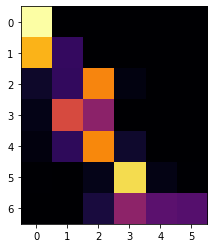

In [123]:
all_vitro_adata = sc.read_h5ad("ALL_VITRO_TIMECOURSE_DATA_RAW.h5ad")

sc.pp.normalize_total(all_vitro_adata, target_sum=1000000)
sc.pp.log1p(all_vitro_adata)

all_vitro_adata = all_vitro_adata[all_vitro_adata.obs["CELL_LINE"]=="HS980"].copy()
all_vitro_adata = all_vitro_adata[all_vitro_adata.obs["CELLTYPE1"].isin(["EMT-RPE", "EarlyRPE", "LateRPE", "MidRPE",
                                                                        "RetProg"])].copy()

all_vitro_adata = all_vitro_adata[:, hv_genes].copy()
all_rpe_class = ord_clf.predict(all_vitro_adata.X)
all_rpe_prob = ord_clf.predict_proba(all_vitro_adata.X)

res_dict = {}
for day in ["D7", "D14", "D30", "D38", "D45", "D60"]:
    res_dict[day] = []
    for ct in ["RET_PROG", "Early_RPE", "Mid1_RPE", "Mid2_RPE", "Late_RPE", "Adult"]:
        res_dict[day].append(sum(all_rpe_class[all_vitro_adata.obs["DAY"]==day]==ct)/len(all_rpe_class[all_vitro_adata.obs["DAY"]==day]))
print(Counter(final_class_vivo))      
res_dict["In Vivo"] = [0, 0, 7/65, 25/65, 17/65, 16/65]

df = pd.DataFrame(res_dict).T
df.columns = ["RET_PROG", "Early_RPE", "Mid1_RPE", "Mid2_RPE", "Late_RPE", "Adult"]

plt.imshow(df, cmap='inferno')

In [124]:
df

,RET_PROG,Early_RPE,Mid1_RPE,Mid2_RPE,Late_RPE,Adult
D7,0.997151,0.002849,0.000000,0.000000,0.000000,0.000000
D14,0.827434,0.170354,0.002212,0.000000,0.000000,0.000000
D30,0.075928,0.166479,0.728909,0.028684,0.000000,0.000000
D38,0.040186,0.577169,0.378567,0.000582,0.000000,0.003494
D45,0.025574,0.157377,0.736393,0.080656,0.000000,0.000000
D60,0.004002,0.001144,0.044025,0.907947,0.036592,0.006289
In Vivo,0.000000,0.000000,0.107692,0.384615,0.261538,0.246154


In [125]:
h9_young = sc.read_h5ad("H9_RPE_YOUNG_Annotated_ProcessedRaw.h5ad")
h9_aged = sc.read_h5ad("H9_RPE_AGED_Annotated_ProcessedRaw.h5ad")

sc.pp.normalize_total(h9_young, target_sum=1000000)
sc.pp.log1p(h9_young)

sc.pp.normalize_total(h9_aged, target_sum=1000000)
sc.pp.log1p(h9_aged)

h9_young=h9_young[:, hv_genes].copy()
h9_aged=h9_aged[:, hv_genes].copy()

h9_young_class = ord_clf.predict(h9_young.X)
h9_aged_class = ord_clf.predict(h9_aged.X)

h9_young_prob = ord_clf.predict_proba(h9_young.X)
h9_aged_prob = ord_clf.predict_proba(h9_aged.X)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [126]:
data["H9_D95"] = h9_young_prob.dot(np.array(estimated_ages))
data["H9_D432"] = h9_aged_prob.dot(np.array(estimated_ages))

In [127]:
data.keys()

dict_keys(['D7_ALL', 'D14_ALL', 'D30_ALL', 'D38_ALL', 'D45_ALL', 'D60_ALL', 'D7_HS980', 'D14_HS980', 'D30_HS980', 'D38_HS980', 'D45_HS980', 'D60_HS980', 'D7_KARO1', 'D14_KARO1', 'D30_KARO1', 'D38_KARO1', 'D45_KARO1', 'D60_KARO1', 'D7_E1C3', 'D14_E1C3', 'D30_E1C3', 'D38_E1C3', 'D45_E1C3', 'D60_E1C3', 'Vivo', 'Embryonic_W5', 'Embryonic_W7', 'D60_HS980_Rep2', 'D60_HS980_Rep3', 'D60_E1C3_Rep2', 'D60_E1C3_Rep3', 'D60_E1C3_Rep4', 'D60_EB', 'D60_Average', 'D60_HS980_ALL', 'D60_E1C3_ALL', 'D38_HS980_Non', 'D60_HS980_Non', 'D38_HS980_RPE', 'D60_HS980_RPE', 'H9_D95', 'H9_D432'])

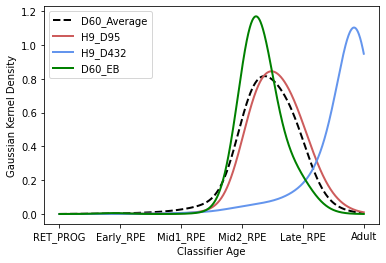

In [128]:
from sklearn.neighbors import KernelDensity


samples = ["D60_Average", "H9_D95", "H9_D432", "D60_EB"]

n2c = {"H9_D432":"cornflowerblue", "H9_D95":"indianred", "D60_EB":"green", 
                      "D60_Average":"black"}
kernel = "gaussian" #'gaussian', 'tophat', 'epanechnikov'
lw = 2

# Plot a 1D density example
distr_dict = {}
for sample in samples:
    X = data[sample].reshape(-1, 1)
    X_plot = np.linspace(0, 5, 1000)[:, np.newaxis]

    kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(X)
    log_dens = kde.score_samples(X_plot)
    distr_dict[sample] = log_dens
    if sample=="D60_Average":
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='--', label=sample, c=n2c[sample])
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
            linestyle='-', label=sample, c=n2c[sample])

    plt.legend(loc='upper left')

legend = plt.legend()
plt.xticks(range(0, 6), ['RET_PROG', 'Early_RPE', 'Mid1_RPE', 'Mid2_RPE', 'Late_RPE', 'Adult'])
plt.xlabel("Classifier Age")
plt.ylabel("Gaussian Kernel Density")
plt.show()

In [129]:
pisco_rpes = sc.read_h5ad("AngelaPiscoRPE.h5ad")

/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [130]:
pisco_rpes_prob, pisco_rpes_class = normalize_and_predict(pisco_rpes, hv_genes, ord_clf)

26


normalizing counts per cell
    finished (0:00:00)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [131]:
Counter(pisco_rpes_class)

Counter({'Adult': 49})

Counter({1.0: 899, 0.0: 483, 2.0: 458, 5.0: 49, 3.0: 5})


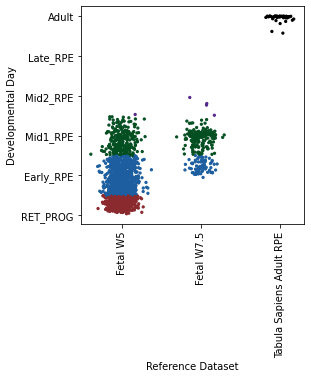

In [132]:
final_prob_all_fetal = np.vstack([final_prob_w5, final_prob_w7, pisco_rpes_prob])

final_prob_mod_fetal = []
for i in range(0, len(final_prob_all_fetal)):
    curr_prob = final_prob_all_fetal[i, :]
    max_prob_pos = np.argmax(final_prob_all_fetal[i, :])
        
    tmp_array = []
    for i in range(0, len(curr_prob)):
        if ((i+1)==(max_prob_pos)) | ((i-1)==(max_prob_pos)) | (i==(max_prob_pos)):
            tmp_array.append(1)
        else:
            tmp_array.append(0)
    curr_prob_mod = curr_prob * np.array(tmp_array)
    final_prob_mod_fetal.append(curr_prob_mod)
final_prob_mod_fetal = np.array(final_prob_mod_fetal)


estimated_ages = [0, 1, 2, 3, 4, 5]
final_prob_date_assignment_fetal = final_prob_all_fetal.dot(np.array(estimated_ages))
final_prob_date_assignment_fetal2 = np.round(final_prob_date_assignment_fetal)

print(Counter(np.round(final_prob_date_assignment_fetal2)))

name2color = {0.0: "RET_PROG", 1.0:"Early_RPE", 2.0:"Mid1_RPE", 3.0:"Mid2_RPE", 4.0:"Late_RPE", 5.0:"Adult"}
prob2colorNAME = {"RET_PROG":"#8a2a2e", "Early_RPE":"#1c5e9f", "Mid1_RPE":"#044f21", 
                  "Mid2_RPE":"#53288d", "Late_RPE":"#ec7f3c", "Adult":"black"}
colors = [prob2colorNAME[name2color[i]] for i in list(final_prob_date_assignment_fetal2)]


v2 = list(final_prob_date_assignment_fetal)
d2 = list([0])*len(final_prob_w5) + list([1])*len(final_prob_w7) + list([2])*len(pisco_rpes_class)
plt.figure(None, (4, 4))
plt.scatter(np.array(d2)+np.random.normal(0, 0.10, len(d2)), v2, s=5,
           c=colors)
plt.xlabel("Reference Dataset")
plt.ylabel("Developmental Day")
plt.xticks([0, 1, 2], ["Fetal W5", "Fetal W7.5", "Tabula Sapiens Adult RPE"], rotation=90)
plt.yticks([i for i in range(0, len(developmental_days_key))], developmental_days_key, rotation=0, rasterized=True)
plt.show()